In [9]:
#Collecting Technical Stock Data

import numpy as np

# Patch for NumPy 2.0+ compatibility
if not hasattr(np, 'NaN'):
    np.NaN = np.nan
if not hasattr(np, 'Inf'):
    np.Inf = np.inf

import yfinance as yf
import pandas_ta as ta

# Define the tickers
tickers = ["RBLX", "^GSPC", "^IXIC"]

# Set your time range
start_date = "2021-03-10"  # Roblox IPO date
end_date = None  

# Fetch historical data
data = yf.download(tickers, start=start_date, end=end_date, group_by='ticker', auto_adjust=True)

# Extract RBLX data and add technical indicators
rblx = data['RBLX'].copy()
rblx['SMA_20'] = ta.sma(rblx['Close'], length=20)
rblx['RSI_14'] = ta.rsi(rblx['Close'], length=14)
rblx['MACD'] = ta.macd(rblx['Close'])['MACD_12_26_9']

# Save to CSV
rblx.to_csv("RBLX_with_technicals.csv")
print("Saved: RBLX_with_technicals.csv")

# Optionally save S&P500 and Nasdaq data too
data['^GSPC'].to_csv("SP500.csv")
data['^IXIC'].to_csv("Nasdaq.csv")
print("Saved: SP500.csv and Nasdaq.csv")



[*********************100%***********************]  3 of 3 completed

Saved: RBLX_with_technicals.csv
Saved: SP500.csv and Nasdaq.csv


In [11]:
import yfinance as yf

SAVE_DIR = "../data/"

rblx = yf.Ticker("RBLX")

# Income statement
rblx.quarterly_financials.to_csv(SAVE_DIR + "RBLX_quarterly_income_statement.csv")
rblx.quarterly_balance_sheet.to_csv(SAVE_DIR + "RBLX_quarterly_balance_sheet.csv")
rblx.quarterly_cashflow.to_csv(SAVE_DIR + "RBLX_quarterly_cashflow.csv")

print("Downloaded all major annual & quarterly financials from Yahoo Finance.")

Downloaded all major annual & quarterly financials from Yahoo Finance.


In [16]:
# Fundamental Data, Gather Information from the SEC (Securities and Exchange Commission.

from sec_edgar_downloader import Downloader

dl = Downloader("RBLX_SEC", "saysaygo@gmail.com", "../data")
CIK = "RBLX"

dl.get("10-K", CIK, after="2021-01-01")
dl.get("10-Q", CIK, after="2021-01-01")
dl.get("8-K", CIK, after="2021-01-01")



40

In [2]:
# User Engagement Data Via RoMonitor

import requests
import pandas as pd
import os

# Define the API endpoints and corresponding filenames
endpoints = {
    "ccu": "https://romonitorstats.com/api/v1/charts/get?name=platform-ccus&timeslice=day&start=2020-01-05T00:00:00.000Z&ends=2025-05-19T23:59:59.999Z",
    "registrations": "https://romonitorstats.com/api/v1/charts/get?name=platform-registrations&timeslice=day&start=2020-03-15T00:00:00.000Z&ends=2025-05-19T23:59:59.999Z",
    "session_length": "https://romonitorstats.com/api/v1/charts/get?name=platform-session-length&timeslice=day&start=2023-04-01T00:00:00.000Z&ends=2025-05-19T23:59:59.999Z",
    "popular_games": "https://romonitorstats.com/api/v1/charts/get?name=platform-sorts&sort=null&timeslice=half-hourly&start=2025-05-06T00:00:00.000Z&ends=2025-05-19T23:59:59.999Z"
}

# Create a directory to store the CSV files
output_dir = "romonitor_data"
os.makedirs(output_dir, exist_ok=True)

for key, url in endpoints.items():
    try:
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()

        if isinstance(data, list):
            df = pd.DataFrame(data)
        else:
            df = pd.DataFrame(data.get("data", []))

        # Save the DataFrame to a CSV file
        output_path = os.path.join(output_dir, f"{key}.csv")
        df.to_csv(output_path, index=False)
        print(f"Saved {key} data to {output_path}")
    except Exception as e:
        print(f"Error fetching {key} data: {e}")




Saved ccu data to romonitor_data\ccu.csv
Saved registrations data to romonitor_data\registrations.csv
Saved session_length data to romonitor_data\session_length.csv
Saved popular_games data to romonitor_data\popular_games.csv


In [2]:
# Sentiment Analysis 

import finnhub
from datetime import datetime, timedelta
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Download VADER lexicon (once):
nltk.download("vader_lexicon")

# Init Finnhub client
api_key = "d0lv0opr01qpni31ielgd0lv0opr01qpni31iem0"
if not api_key:
    raise RuntimeError("Please set FINNHUB_API_KEY")
client = finnhub.Client(api_key=api_key)

# Fetch company news for RBLX over the last 30 days
to_date = datetime.today()
from_date = to_date - timedelta(days=365)
news = client.company_news(
    symbol="RBLX",
    _from=from_date.strftime("%Y-%m-%d"),
    to=to_date.strftime("%Y-%m-%d")
)
# Each item has: id, headline, summary, url, source, datetime

# Compute sentiment scores with VADER
sia = SentimentIntensityAnalyzer()
results = []
for article in news:
    text = (article.get("headline", "") + "\n" + article.get("summary", "")).strip()
    vs = sia.polarity_scores(text)
    results.append({
        "date": datetime.fromtimestamp(article["datetime"]).date(),
        "headline": article["headline"],
        **vs
    })

# Aggregate daily average compound score
from collections import defaultdict
agg = defaultdict(list)
for r in results:
    agg[r["date"]].append(r["compound"])
daily_sentiment = {
    date: sum(scores)/len(scores)
    for date, scores in agg.items()
}

# Print or save
for date, avg in sorted(daily_sentiment.items()):
    print(f"{date} → Avg Compound Sentiment = {avg:.3f}")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\saysa\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


2024-11-04 → Avg Compound Sentiment = 0.532
2024-11-05 → Avg Compound Sentiment = 0.440
2024-11-06 → Avg Compound Sentiment = 0.218
2024-11-07 → Avg Compound Sentiment = 0.440
2024-11-11 → Avg Compound Sentiment = -0.181
2024-11-13 → Avg Compound Sentiment = 0.527
2024-11-14 → Avg Compound Sentiment = 0.340
2024-11-15 → Avg Compound Sentiment = 0.927
2024-11-17 → Avg Compound Sentiment = 0.527
2024-11-18 → Avg Compound Sentiment = 0.019
2024-11-19 → Avg Compound Sentiment = 0.691
2024-11-20 → Avg Compound Sentiment = 0.273
2024-11-22 → Avg Compound Sentiment = 0.650
2024-11-25 → Avg Compound Sentiment = 0.535
2024-11-27 → Avg Compound Sentiment = 0.778
2024-12-02 → Avg Compound Sentiment = 0.799
2024-12-03 → Avg Compound Sentiment = 0.464
2024-12-06 → Avg Compound Sentiment = 0.934
2024-12-07 → Avg Compound Sentiment = 0.653
2024-12-09 → Avg Compound Sentiment = 0.700
2024-12-11 → Avg Compound Sentiment = -0.226
2024-12-12 → Avg Compound Sentiment = 0.491
2024-12-13 → Avg Compound Sent

In [3]:

# import/save this into a csv file
df = pd.DataFrame([
    {"date": date, "avg_sentiment": avg}
    for date, avg in sorted(daily_sentiment.items())
])
df.to_csv("rblx_news_sentiment.csv", index=False)
print("Saved as rblx_news_sentiment.csv")

Saved as rblx_news_sentiment.csv


In [5]:
import yfinance as yf
import pandas as pd

# Load your sentiment csv
sentiment = pd.read_csv("rblx_news_sentiment.csv")

price = yf.download("RBLX", start=sentiment["date"].min(), end=sentiment["date"].max())

# If price columns are a MultiIndex, flatten them
if isinstance(price.columns, pd.MultiIndex):
    price.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in price.columns]

# Reset index and ensure 'date' is in '%Y-%m-%d' string format
price = price.reset_index()
if 'Date' in price.columns:
    price["date"] = price["Date"].dt.strftime("%Y-%m-%d")
elif 'index' in price.columns:
    price["date"] = price["index"].dt.strftime("%Y-%m-%d")

# Select only 'date' and 'Close' (or 'Close_' if needed)
close_col = [col for col in price.columns if 'Close' in col][0]
price = price[['date', close_col]].rename(columns={close_col: 'Close'})

# Now merge
merged = pd.merge(sentiment, price, on="date", how="inner")

[*********************100%***********************]  1 of 1 completed


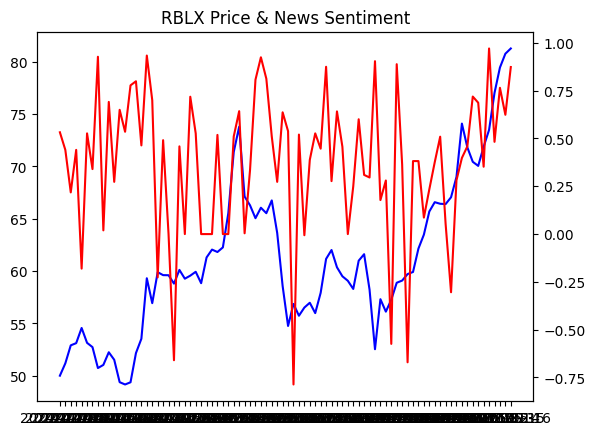

In [6]:
# Quick plot
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()
ax1.plot(merged["date"], merged["Close"], label="Close Price", color="blue")
ax2 = ax1.twinx()
ax2.plot(merged["date"], merged["avg_sentiment"], label="Avg Sentiment", color="red")
plt.title("RBLX Price & News Sentiment")
plt.show()

In [7]:
import yfinance as yf
import pandas as pd

# List of context tickers
context_tickers = ['^GSPC', '^IXIC', '^VIX', '^TNX', 'XLC']

# Choose a date range matching your sentiment/news data
start_date = sentiment['date'].min()
end_date = sentiment['date'].max()

# Download context data (daily Close)
context_data = yf.download(context_tickers, start=start_date, end=end_date)['Close']
context_data = context_data.reset_index()
context_data['date'] = context_data['Date'].dt.strftime('%Y-%m-%d')
context_data = context_data.drop(columns=['Date'])

# Save as CSV for later merging
context_data.to_csv('market_context_data.csv', index=False)
print(context_data.head())


[*********************100%***********************]  5 of 5 completed

Ticker        XLC        ^GSPC         ^IXIC   ^TNX   ^VIX        date
0       91.580170  5712.689941  18179.980469  4.309  21.98  2024-11-04
1       92.594536  5782.759766  18439.169922  4.289  20.49  2024-11-05
2       94.871849  5929.040039  18983.470703  4.426  16.27  2024-11-06
3       96.114937  5973.100098  19269.460938  4.341  15.20  2024-11-07
4       95.647537  5995.540039  19286.779297  4.306  14.94  2024-11-08
